In [1]:
from matplotlib import pyplot
import numpy as np
import sys
import tqdm
import ipywidgets
import pickle
import copy
import os

In [2]:
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture

In [3]:
# from https://github.com/DaWelter/face-3d-rotation-augmentation
from face3drotationaugmentation.dataset300wlp import Dataset300WLP

In [4]:
f = Dataset300WLP(os.path.join(os.environ['ORIGINAL_DATA_DIR'],'300W-LP.zip'), only_originals=True)

In [5]:
def extract(s):
    return s['shapeparam'], s['scale']

items = [ extract(s) for s in tqdm.tqdm(f) ]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3837/3837 [00:09<00:00, 390.70it/s]


In [6]:
shapeparams, scales = zip(*items)
shapeparams = np.stack(shapeparams)
scales = np.stack(scales)

# Distribution of shapeparams?

In [8]:
N = shapeparams.shape[-1]
@ipywidgets.interact(i=(0,N-1),j=(0,N-1))
def plot(i,j):
    pyplot.scatter(shapeparams[:,i],shapeparams[:,j], alpha=0.01)

interactive(children=(IntSlider(value=24, description='i', max=49), IntSlider(value=24, description='j', max=4…

In [9]:
shapeparams_means = np.average(shapeparams, axis=0)[None,:]
mean_subtracted = shapeparams - np.average(shapeparams, axis=0)[None,:]

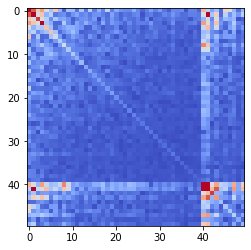

In [10]:
cov = np.cov(mean_subtracted, rowvar=False)
pyplot.imshow(np.sqrt(np.abs(cov)), vmin=0., vmax=np.amax(cov), cmap='coolwarm')

# Let's build a gaussian mixture model

With it I can put a loss on the (un)likelihood of predicted parameters

In [11]:
gm = GaussianMixture(n_components=10, covariance_type='diag', random_state=0, init_params='kmeans', n_init=10, tol=1.e-3, reg_covar=1.e-7).fit(shapeparams)

generated, _ = gm.sample(5000)

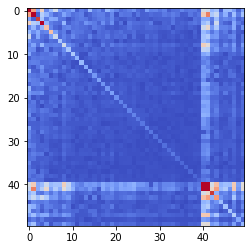

In [12]:
cov = np.cov(generated - np.average(generated,axis=0)[None,:], rowvar=False)
pyplot.imshow(np.sqrt(np.abs(cov)), vmin=0., vmax=np.amax(cov), cmap='coolwarm')

In [13]:
@ipywidgets.interact(i=(0,N-1),j=(0,N-1))
def plot(i,j):
    pyplot.scatter(shapeparams[:,i], shapeparams[:,j], alpha=0.01, c='b')
    pyplot.scatter(generated[:,i], generated[:,j], alpha=0.01, c='r')
    pyplot.scatter(gm.means_[:,i], gm.means_[:,j], c='r', marker='x')

interactive(children=(IntSlider(value=24, description='i', max=49), IntSlider(value=24, description='j', max=4…

In [208]:
with open('../trackertraincode/facemodel/shapeparams_gmm.pkl','wb') as f:
    pickle.dump(gm, f)